Based on:
* https://github.com/bodias/ViT-pytorch
* https://jacobgil.github.io/deeplearning/vision-transformer-explainability
    

In [15]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms, datasets

from models.modeling import VisionTransformer, CONFIGS

## Download ViT model and model labels

In [16]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

## Download CalTech dataset
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [17]:
# Download and Save caltech dataset 
os.makedirs("caltech", exist_ok=True)
dataset = datasets.caltech.Caltech101('caltech/', download=True)

Files already downloaded and verified


The label of the image is: flamingo


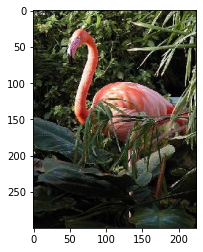

In [58]:
sample = np.random.randint(low=1000, high=len(dataset))
random_image = dataset[sample][0]
random_image_label = dataset[sample][1]

plt.imshow(random_image)
print("The label of the image is:", dataset.annotation_categories[random_image_label])

In [19]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [59]:
x = transform(random_image)

In [61]:
def predict(x):
    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Last layer attention map
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    last_layer = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    last_layer = cv2.resize(last_layer / last_layer.max(), (112,112))[..., np.newaxis]
    
    #classification result
    probs = torch.nn.Softmax(dim=-1)(logits)
    top5 = torch.argsort(probs, dim=-1, descending=True)
    clf_results = {}
    for top_n in top5[0, :5].detach().numpy():    
        clf_results[top_n] = float(probs[0, top_n].detach().numpy())
        
    #all attention layers for visualization
    all_att_layers = []
    for v in aug_att_mat:
        att_lyr = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
        att_lyr = cv2.resize(att_lyr / att_lyr.max(), (112,112))#[..., np.newaxis]
        all_att_layers.append(att_lyr)          
    
    return clf_results, last_layer, all_att_layers

Prediction Label and attention map

0.99878 : flamingo
0.00005 : black_stork, Ciconia_nigra
0.00005 : crane
0.00004 : black_swan, Cygnus_atratus
0.00004 : pelican


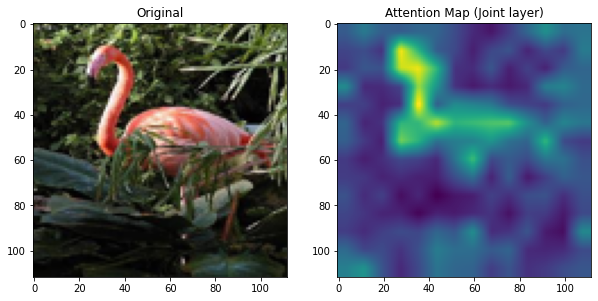

In [70]:
clf_results, last_attention_map, all_attention_maps = predict(x)
print("Prediction Label and attention map\n")
for class_id, conf in clf_results.items():
    print(f'{conf:.5f} : {imagenet_labels[class_id]}', end='')
    
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title('Attention Map (Joint layer)')
_ = ax1.imshow(random_image.resize((112,112)))
_ = ax2.imshow(last_attention_map)

## Show 4 random objects and all 12 attention layers

In [77]:
random_sample = np.random.randint(low=1000, high=len(dataset), size=(4))
random_sample

array([1231, 1497, 5226, 3325])

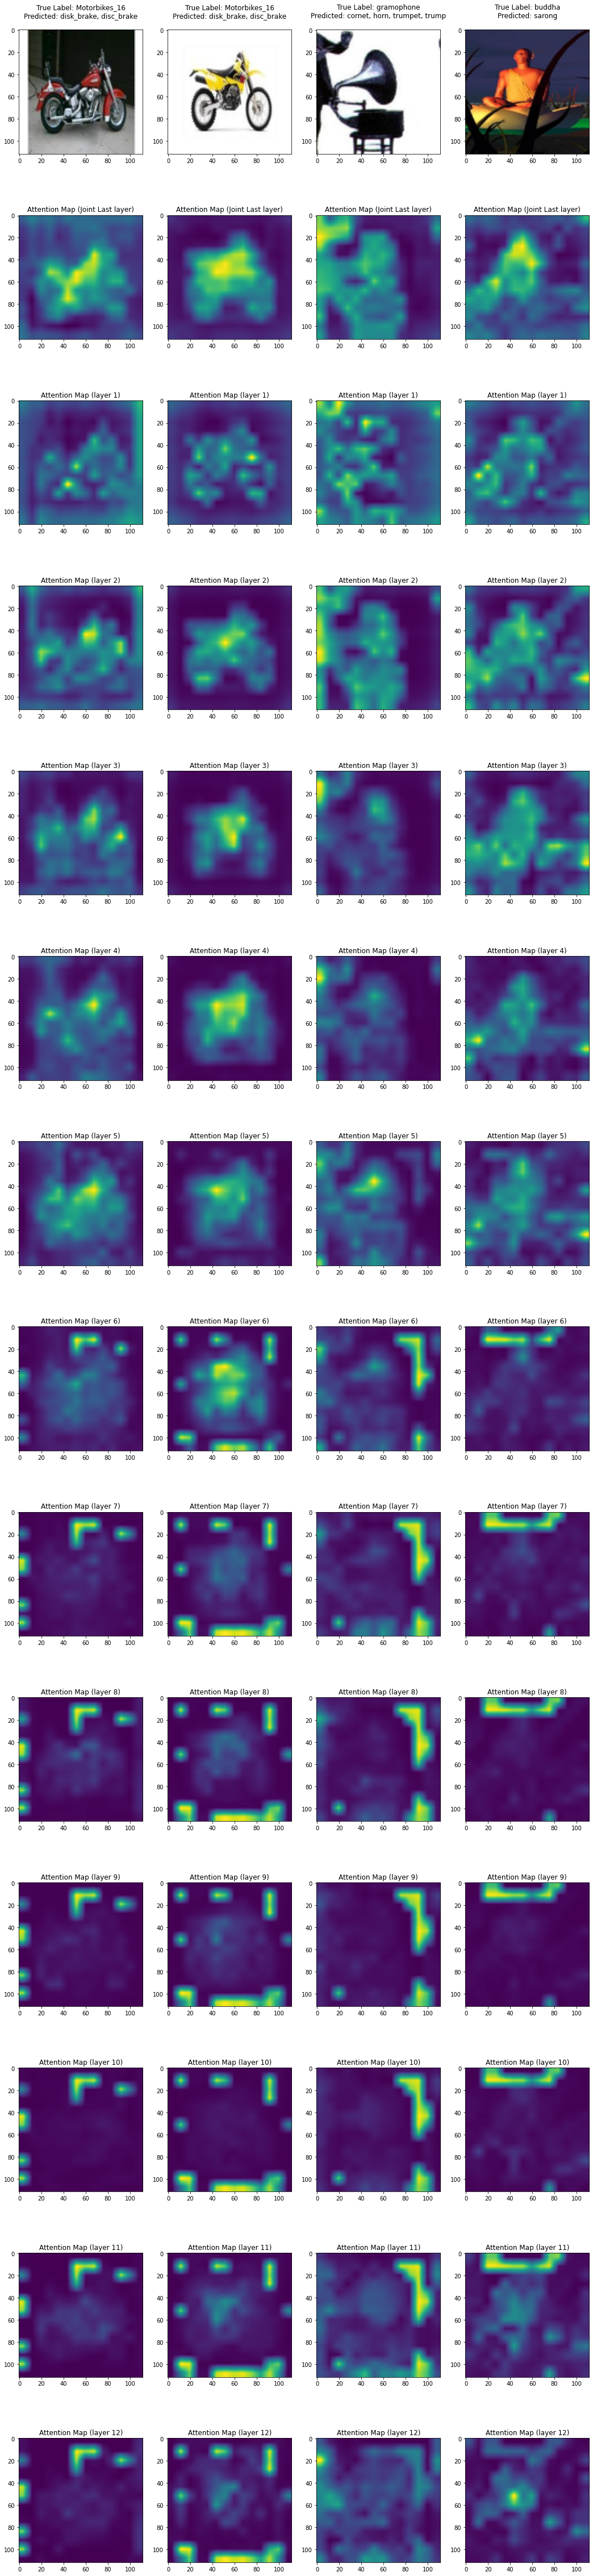

In [78]:
fig, axs = plt.subplots(nrows=14, ncols=4, figsize=(18, 83))

for idx, sample_idx in enumerate(random_sample):
    sample_image, sample_label = dataset[sample_idx]
    true_label = dataset.annotation_categories[sample_label]
    
    clf_results, last_attention_map, all_attention_maps = predict(transform(sample_image))
    predicted_label, conf = next(iter(clf_results.items()))
    predicted_label = imagenet_labels[predicted_label]
    
    axs[0, idx].set_title(f'True Label: {true_label}\nPredicted: {predicted_label}')
    axs[0, idx].imshow(sample_image.resize((112,112)))
    axs[1, idx].set_title(f'Attention Map (Joint Last layer)')
    axs[1, idx].imshow(last_attention_map)
    
    for layer_i, att_layer in enumerate(all_attention_maps):
        axs[layer_i+2, idx].set_title(f'Attention Map (layer {layer_i+1})')
        axs[layer_i+2, idx].imshow(att_layer)

plt.show()